In [4]:
from __future__ import print_function
from matplotlib import pyplot as plt
import mxnet as mx
import numpy as np
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn

In [5]:
ctx = mx.gpu()

In [7]:
X = nd.random_normal(shape=(1000, 2))
A = nd.array([[1, 2], [-.1, .5]])
b = nd.array([1, 2])
X = nd.dot(X, A) + b
Y = nd.ones(shape=(1000, 1))

batch_size = 4
train_data = mx.io.NDArrayIter(X, Y, batch_size, shuffle=True)

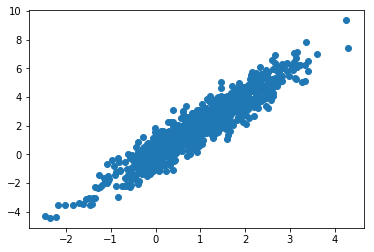


[[ 5.          0.89999998]
 [ 0.89999998  0.25999999]]
<NDArray 2x2 @cpu(0)>


In [8]:
plt.scatter(X[:,0].asnumpy(), X[:,1].asnumpy())
plt.show()
print(nd.dot(A, A.T))

In [9]:
netG = nn.Sequential()
with netG.name_scope():
    netG.add(nn.Dense(2))
    
netD = nn.Sequential()
with netD.name_scope():
    netD.add(nn.Dense(5, activation='tanh'))
    netD.add(nn.Dense(3, activation='tanh'))
    netD.add(nn.Dense(2))
    
loss = gluon.loss.SoftmaxCrossEntropyLoss()

netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': 0.01})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': 0.05})

In [13]:
real_label = mx.nd.ones((batch_size,), ctx=ctx)
fake_label = mx.nd.zeros((batch_size,), ctx=ctx)
metric = mx.metric.Accuracy()

# set up logging
from datetime import datetime
import os
import time


binary training acc at epoch 0: accuracy=0.452000
time: 0.645203


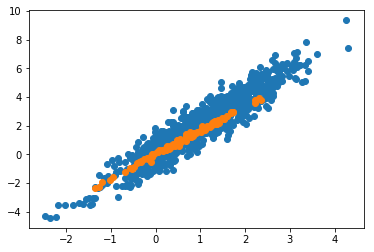


binary training acc at epoch 1: accuracy=0.451500
time: 0.809013


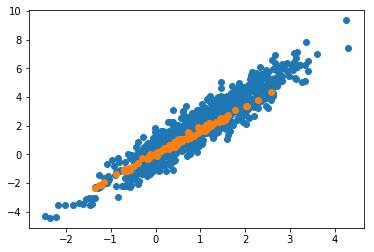


binary training acc at epoch 2: accuracy=0.450500
time: 0.661328


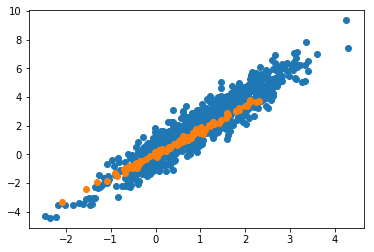


binary training acc at epoch 3: accuracy=0.475500
time: 0.753960


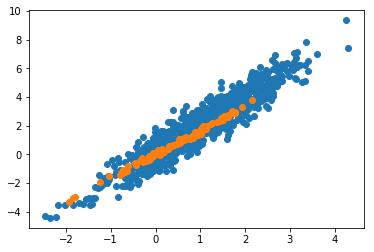


binary training acc at epoch 4: accuracy=0.452500
time: 0.745368


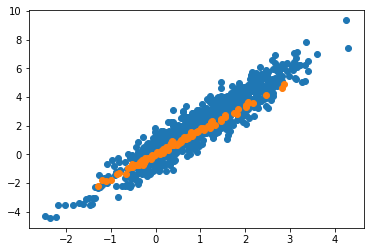


binary training acc at epoch 5: accuracy=0.457500
time: 0.793170


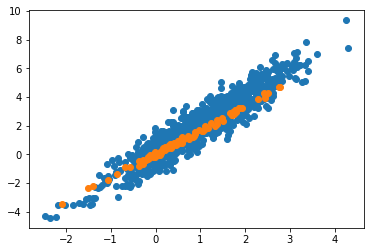


binary training acc at epoch 6: accuracy=0.461000
time: 0.645635


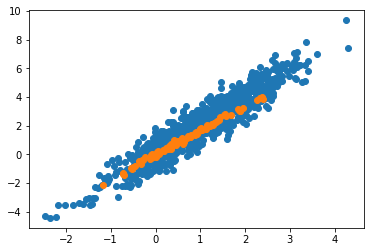


binary training acc at epoch 7: accuracy=0.468500
time: 0.706617


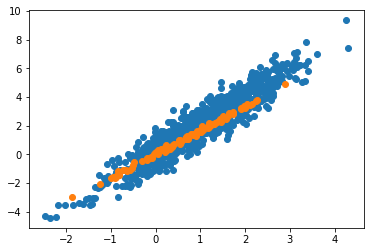


binary training acc at epoch 8: accuracy=0.451500
time: 0.755163


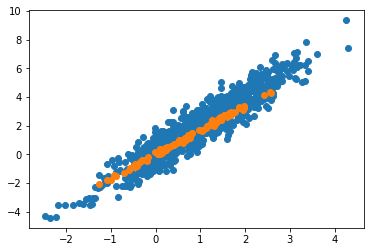


binary training acc at epoch 9: accuracy=0.473000
time: 0.770102


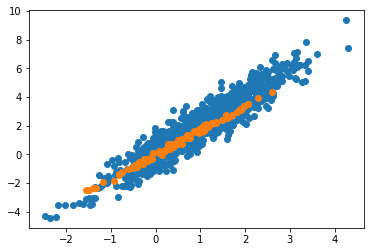

In [16]:
stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')

for epoch in range(10):
    tic = time.time()
    train_data.reset()
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        noise = nd.random_normal(shape=(batch_size, 2), ctx=ctx)
        
        with autograd.record():
            real_output = netD(data)
            errD_real = loss(real_output, real_label)
            
            fake = netG(noise)
            fake_output = netD(fake.detach())
            errD_fake = loss(fake_output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
        
        trainerD.step(batch_size)
        metric.update([real_label,], [real_output,])
        metric.update([fake_label,], [fake_output,])
        
        with autograd.record():
            output = netD(fake)
            errG = loss(output, real_label)
            errG.backward()
        
        trainerG.step(batch_size)
    
    name, acc = metric.get()
    metric.reset()
    print('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    print('time: %f' % (time.time() - tic))
    
    noise = nd.random_normal(shape=(100, 2), ctx=ctx)
    fake = netG(noise)
    plt.scatter(X[:, 0].asnumpy(),X[:,1].asnumpy())
    plt.scatter(fake[:,0].asnumpy(),fake[:,1].asnumpy())
    plt.show()